### Regional Mask

This notebook is for creating regional mask in Labrador sea, Irminger sea, Iceland basin and other regions. These masked arrays would be useful in performing computations within those enclosed regions.

In [1]:
import numpy as np
import xarray as xr
import regionmask
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cmip6_preprocessing.regionmask import merged_mask
import regionmask

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read SST file for getting lat-lon

ppdir="../../../Data/DePreSys4_Met/Grid_Data/"

ds = xr.open_dataset(ppdir + "2008_tos.nc", decode_times= False) 
ds = xr.decode_cf(ds)

ds_area = xr.open_dataset(ppdir + "Area.nc")
ds_area = ds_area.get(['area_t'])
ds_area = ds_area.rename({'x':'i', 'y':'j'})

ds = xr.merge([ds, ds_area])

print(ds)

FileNotFoundError: [Errno 2] No such file or directory: b'/home/users/hkhatri/Git_Repo/Data/DePreSys4_Met/Grid_Data/2008_tos.nc'

In [4]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?'):
    
    #contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.6) # orientation="horizontal"
    cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    #gl.ylocator = mticker.FixedLocator([-80, -70, -60, -50, -40, -30])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    #ax.coastlines()
    #ax.add_feature(cfeature.LAND) #facecolor='black')
    #ax.add_feature(cfeature.COASTLINE)
    ax.set_aspect(1.0)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    _ = plt.title(title, fontsize=14)
    return fig

#### Coordinates for defining regions

Here, we define different regions and assingn coordinate values. Note that these regions also have points over the land. This is just the first step for generating the masked for specific ocean regions. In the next step, we will excude the land gridpoints before generating the final grid masks.

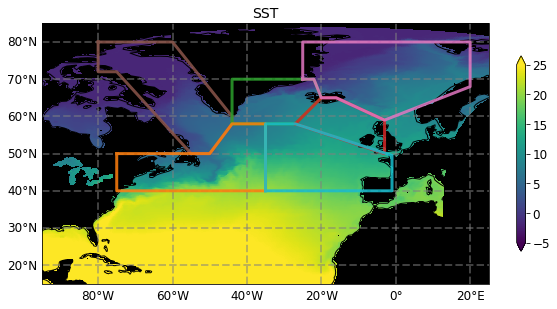

In [4]:
lat_lon_ext = [-95., 25., 15., 85.]
grid1 = plt.GridSpec(1, 1, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[10,6])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='black')

tmp = ds.tos.isel(r=0,time=0) #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=-5., vmax=25., vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='viridis', title=r'SST')

# Add Labrador Sea Box

lab_y = [80., 72., 72., 50., 50., 58., 60., 80., 80.]
lab_x = [-80., -80, -75., -55., -50., -44., -44., -60., -80.] 
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:brown', alpha = 0.85, transform=ccrs.PlateCarree())

# Add Irminger Sea box
lab_y = [58., 70., 70., 65., 58., 58.]
lab_x = [-44., -44., -22., -20., -27., -44.]
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:green', alpha = 0.85, transform=ccrs.PlateCarree())

# Add Iceland Basin box
lab_y = [58., 65., 65., 59., 50., 58.]
lab_x = [-27., -20., -16., -3., -3., -27.]
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:red', alpha = 0.85, transform=ccrs.PlateCarree())

# Add NE box
lab_y = [70., 80., 80., 68., 59., 65., 65., 70., 70.]
lab_x = [-25., -25., 20., 20., -3., -16., -20., -22., -25.]
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:pink', alpha = 0.85, transform=ccrs.PlateCarree())

# Add SW region box
lab_y = [50., 40., 40., 58., 58., 50., 50.]
lab_x = [-75., -75., -35., -35., -44., -50., -75.]
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:orange', alpha = 0.85, transform=ccrs.PlateCarree())

# Add SE region box
lab_y = [40., 58., 58., 49.5, 40., 40.]
lab_x = [-35., -35., -27., -1., -1., -35.]
ax.plot(lab_x,lab_y, linestyle='-', lw = 3, color = 'tab:cyan', alpha = 0.85, transform=ccrs.PlateCarree())

#### Final Masked Grids

Here, we make use of regionmask library to generate maskedgrids. We then use information from SST to exclude landpoints from these masked grids. These grids are then saved in separate nc files for use in the future.

In [5]:
Labrador = np.array([[-80., -80, -75., -55., -50., -44., -44., -60., -80.], 
                     [80., 72., 72., 50., 50., 58., 60., 80., 80.]]).transpose()

Irminger = np.array([[-44., -44., -22., -20., -27., -44.], 
                   [58., 70., 70., 65., 58., 58.]]).transpose()

Iceland = np.array([[-27., -20., -16., -3., -3., -27.], 
                   [58., 65., 65., 59., 50., 58.]]).transpose()

North_east = np.array([[-25., -25., 20., 20., -3., -16., -20., -22., -25.], 
                       [70., 80., 80., 68., 59., 65., 65., 70., 70.]]).transpose()

South_west = np.array([[-75., -75., -35., -35., -44., -50., -75.], 
                       [50., 40., 40., 58., 58., 50., 50.]]).transpose()

South_east = np.array([[-35., -35., -27., -1., -1., -35.], 
                       [40., 58., 58., 49.5, 40., 40.]]).transpose()

In [6]:
names = ["Labrador Sea", "Irminger Sea", "Iceland Basin", "North East Region", "South West Region", 
         "South East Region"]

abbrevs = ["Lab", "Irm", "Ice", "NE", "SW", "SE"]

Ocean_Regions = regionmask.Regions([Labrador, Irminger, Iceland, North_east, South_west, South_east], 
                                   names=names, abbrevs=abbrevs, name="Subpolar North Atlantic")
Ocean_Regions

<regionmask.Regions>
Name:     Subpolar North Atlantic

Regions:
0 Lab      Labrador Sea
1 Irm      Irminger Sea
2 Ice     Iceland Basin
3  NE North East Region
4  SW South West Region
5  SE South East Region

[6 regions]

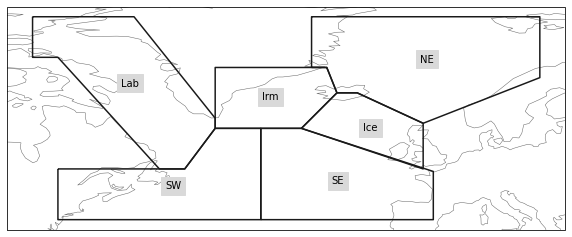

In [7]:
fig = plt.figure(figsize=[10,6])
ax = Ocean_Regions.plot(label="abbrev")

In [8]:
# Create Mask

mask = Ocean_Regions.mask(ds.longitude, ds.latitude)

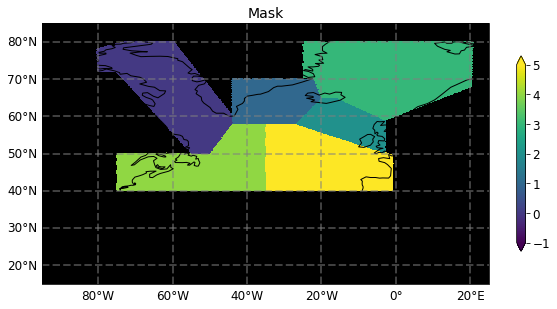

In [9]:
lat_lon_ext = [-95., 25., 15., 85.]
grid1 = plt.GridSpec(1, 1, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[10,6])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='black')

tmp = mask.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=-1., vmax=5., vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='viridis', title=r'Mask')

In [10]:
mask1 = mask.copy()

SST = ds.tos.isel(r=0,time=0)

mask1 = mask1.where(SST < 100.) # Get gripoints where SST is not nan

# In xr.where(condition, a, b), replace data with a where conditions are satisfied. Otherwise, replace data with b.
# On the other hand, mask.where(condition, b) replaces data with b where conditions are not satisfied satisfied and 
# keeps the original data in mask where conditions are satisfied.

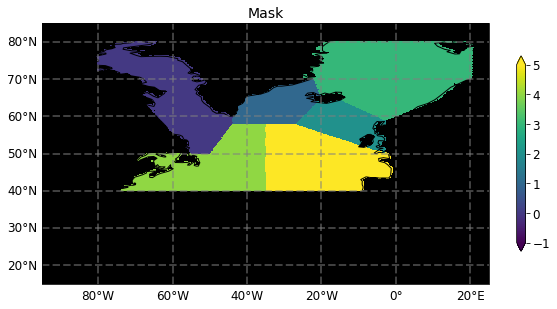

In [11]:
lat_lon_ext = [-95., 25., 15., 85.]
grid1 = plt.GridSpec(1, 1, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[10,6])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='black')

tmp = mask1.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=-1., vmax=5., vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='longitude', lat='latitude', cmap='viridis', title=r'Mask')

### North Atlantic mask

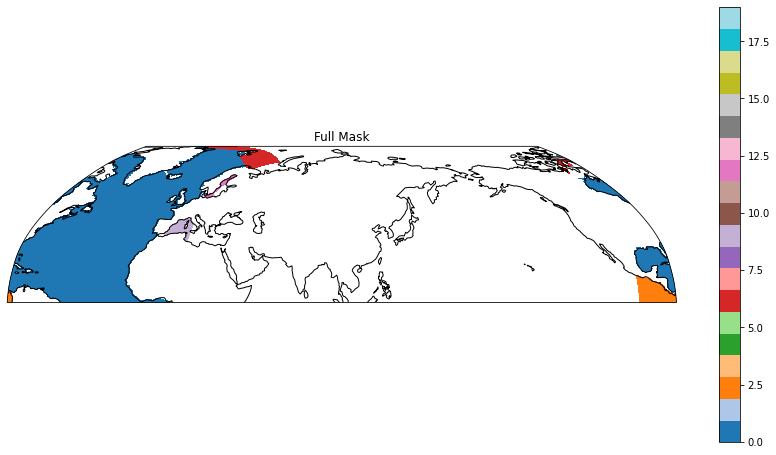

In [28]:
basins = regionmask.defined_regions.natural_earth.ocean_basins_50

mask_NA = merged_mask(basins, ds, lon_name="longitude", lat_name="latitude")

kwargs = dict(x='longitude', y='latitude',transform = ccrs.PlateCarree(), infer_intervals=False)

fig, ax = plt.subplots(ncols=1, figsize=[15,8], subplot_kw={'projection':ccrs.Robinson(100)})

mask_NA.plot(cmap='tab20', vmin=0, vmax=19, **kwargs)
ax.set_title(f"Full Mask")
ax.coastlines()

In [29]:
# Save mask grids

mask_save = xr.Dataset()

mask_save['mask_regions'] = mask1.drop(['time', 'lat', 'lon', 'latitude', 'longitude'])

mask_save['mask_North_Atl'] = mask_NA.drop(['latitude', 'longitude'])

print(mask_save)

save_path="../../../Data/DePreSys4_Met/Grid_Data/"

mask_save.to_netcdf(save_path + 'Mask_Regions.nc')

<xarray.Dataset>
Dimensions:         (j: 450, i: 450)
Coordinates:
  * j               (j) int64 699 700 701 702 703 ... 1144 1145 1146 1147 1148
  * i               (i) int64 749 750 751 752 753 ... 1194 1195 1196 1197 1198
    nav_lat         (j, i) float32 ...
    nav_lon         (j, i) float32 ...
Data variables:
    mask_regions    (j, i) float64 nan nan nan nan nan ... nan nan nan nan nan
    mask_North_Atl  (j, i) float64 2.0 2.0 2.0 2.0 2.0 ... 6.0 6.0 6.0 6.0 6.0


### Mask for v-grid

This is to create masks for v-grid for overturning calculation, which requires regridding of meridional transport data on lat-lon grid for calculations.   

In [25]:
path = "/home/users/hkhatri/DePreSys4_Data/Test_Data/ONM_Monthly/"

ds_V = xr.open_dataset(path + "nemo_av830o_1m_19810301-19810401_grid-V.nc")
ds_V = ds_V.isel(x=slice(750,1200), y = slice(700, 1150)) # region of interest 
#ds_V = ds_V.isel(x=slice(750,1450), y = slice(700, 1150))

#ds_V = xr.open_dataset("/gws/nopw/j04/snapdragon/hkhatri/Data_Drift/vo/Drift_vo_r1_Lead_Year_1.nc")
#ds_V = ds_V.rename({'latitude':'nav_lat', 'longitude':'nav_lon', 'time':'time_counter', 'lev':'depthv'})

print(ds_V)

<xarray.Dataset>
Dimensions:               (y: 450, x: 450, nvertex: 4, depthv: 75,
                           axis_nbounds: 2, time_counter: 1)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
  * depthv                (depthv) float32 0.5058 1.556 ... 5.698e+03 5.902e+03
    time_centered         (time_counter) object ...
  * time_counter          (time_counter) float64 0.0
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables: (12/15)
    bounds_lon            (y, x, nvertex) float32 ...
    bounds_lat            (y, x, nvertex) float32 ...
    area                  (y, x) float32 ...
    depthv_bounds         (depthv, axis_nbounds) float32 ...
    thkcello              (time_counter, depthv, y, x) float32 ...
    time_centered_bounds  (time_counter, axis_nbounds) object ...
    ...                    ...
    vso                   (time_counter, depthv, y, x) float32 ...
    vmo                   (time_counte

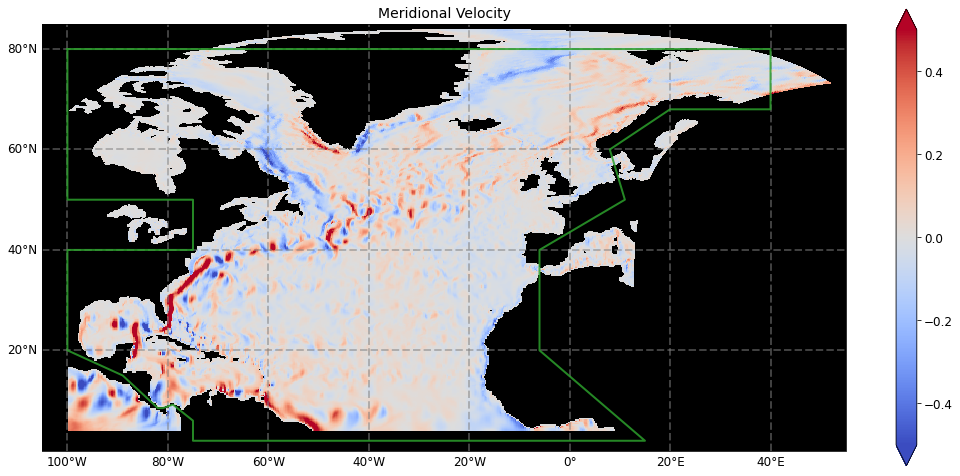

In [26]:
lat_lon_ext = [-105., 55., 0., 85.]
grid1 = plt.GridSpec(1, 1, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[18,14])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='black')

tmp = ds_V['vo'].isel(time_counter=0,depthv=0).load() #.assign_coords({'lat': ds['latitude'], 'lon': ds['longitude']})
p = plot_sec(ax, tmp, vmin=-0.5, vmax=0.5, vstep=2.e-1, lat_lon_ext = lat_lon_ext,
                   lon='nav_lon', lat='nav_lat', cmap='coolwarm', title=r'Meridional Velocity')

# Add North Atlantic Box

lab_y = [80., 80., 68., 68., 60., 50., 40., 20., 2., 2., 6., 9.2, 8.5, 8.5, 15., 20., 40., 40., 50., 50., 80.]
lab_x = [-100., 40., 40., 20., 8., 11., -6, -6, 15., -75., -75., -79., -81., -82., -89., -100., -100., -75., -75., -100., -100.] 
ax.plot(lab_x,lab_y, linestyle='-', lw = 2, color = 'tab:green', alpha = 0.85, transform=ccrs.PlateCarree())

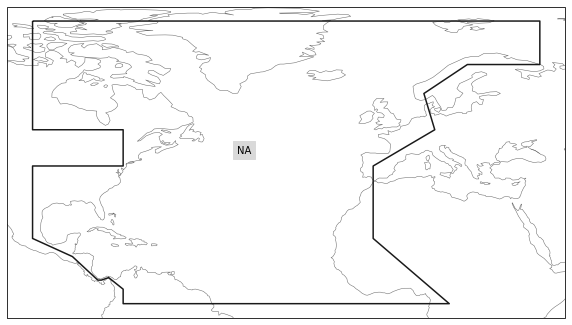

In [27]:
North_Atl = np.array([[-100., 40., 40., 20., 8., 11., -6, -6, 15., -75., -75., -79., -81., -82., -89., -100., -100., -75., -75., -100., -100.], 
                     [80., 80., 68., 68., 60., 50., 40., 20., 2., 2., 6., 9.2, 8.5, 8.5, 15., 20., 40., 40., 50., 50., 80.]]).transpose()

names = ["North Atlantic"]
abbrevs = ["NA"]

Ocean_Regions = regionmask.Regions([North_Atl], 
                                   names=names, abbrevs=abbrevs, name="Subpolar North Atlantic")
Ocean_Regions

fig = plt.figure(figsize=[10,6])
ax = Ocean_Regions.plot(label="abbrev")

mask = Ocean_Regions.mask(ds_V.nav_lon, ds_V.nav_lat)
mask1 = mask.copy()

tmp = ds_V['vo'].isel(time_counter=0,depthv=0).load()

mask1 = mask1.where(tmp < 100.)

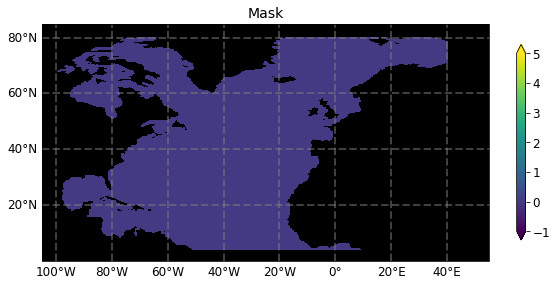

In [28]:
lat_lon_ext = [-105., 55., 0., 85.]
grid1 = plt.GridSpec(1, 1, wspace=0.15, hspace=0.3)
fig = plt.figure(figsize=[10,6])
    
ax = fig.add_subplot(grid1[0, 0], projection=ccrs.PlateCarree(),facecolor='black')

tmp = mask1.assign_coords({'lat': ds_V.nav_lat, 'lon': ds_V.nav_lon})
p = plot_sec(ax, tmp, vmin=-1., vmax=5., vstep=2.e-3, lat_lon_ext = lat_lon_ext,
                   lon='lon', lat='lat', cmap='viridis', title=r'Mask')

In [14]:
mask1

<xarray.DataArray 'mask' (y: 450, x: 450)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    nav_lat        (y, x) float32 4.121 4.121 4.121 4.121 ... 73.47 73.36 73.26
    nav_lon        (y, x) float32 -99.75 -99.5 -99.25 ... 51.27 51.43 51.59
    depthv         float32 0.5058
    time_centered  object 1981-03-16 00:00:00
    time_counter   float64 0.0
Dimensions without coordinates: y, x

In [15]:
# Save mask grids

mask_save = xr.Dataset()

mask_save['mask_North_Atl'] = mask1.drop(['depthv', 'time_centered', 'time_counter'])

mask_save = mask_save.rename({'y':'j', 'x':'i'}) 

print(mask_save)

save_path="/home/users/hkhatri/DePreSys4_Data/Data_Consolidated/"

mask_save.to_netcdf(save_path + 'Mask_V_grid.nc')

<xarray.Dataset>
Dimensions:         (j: 450, i: 450)
Coordinates:
    nav_lat         (j, i) float32 4.121 4.121 4.121 4.121 ... 73.47 73.36 73.26
    nav_lon         (j, i) float32 -99.75 -99.5 -99.25 ... 51.27 51.43 51.59
Dimensions without coordinates: j, i
Data variables:
    mask_North_Atl  (j, i) float64 nan nan nan nan nan ... nan nan nan nan nan
